  0%|          | 0/25 [00:00<?, ?it/s]

G pre-trained for 5 training steps.
Epoch[1/25], G Loss: -0.0880, D Loss: 0.3385


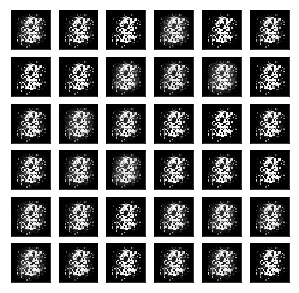

  4%|▍         | 1/25 [00:13<05:19, 13.31s/it]

Epoch[2/25], G Loss: -0.1966, D Loss: 0.3846


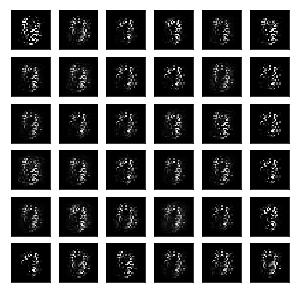

  8%|▊         | 2/25 [00:29<05:34, 14.55s/it]

Epoch[3/25], G Loss: -0.1005, D Loss: 0.1912


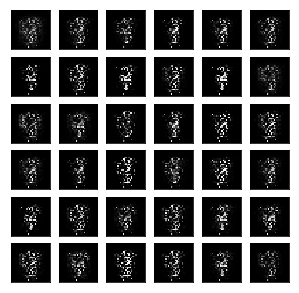

 12%|█▏        | 3/25 [00:51<06:15, 17.05s/it]

Epoch[4/25], G Loss: -0.0615, D Loss: 0.1043


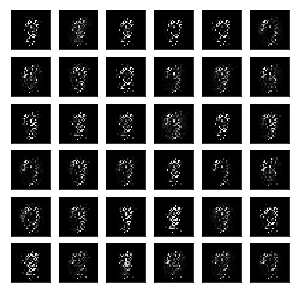

 16%|█▌        | 4/25 [01:13<06:27, 18.47s/it]

Epoch[5/25], G Loss: -0.0456, D Loss: 0.0835


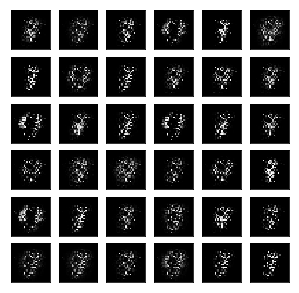

 20%|██        | 5/25 [01:42<06:49, 20.47s/it]

Epoch[6/25], G Loss: -0.0370, D Loss: 0.0823


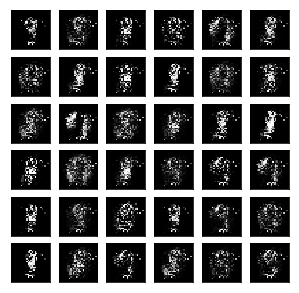

 24%|██▍       | 6/25 [02:10<06:54, 21.82s/it]

Epoch[7/25], G Loss: -0.0555, D Loss: 0.1736


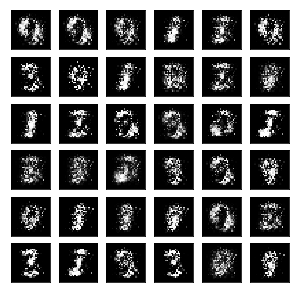

 28%|██▊       | 7/25 [02:40<06:53, 22.95s/it]

Epoch[8/25], G Loss: -0.0795, D Loss: 0.2255


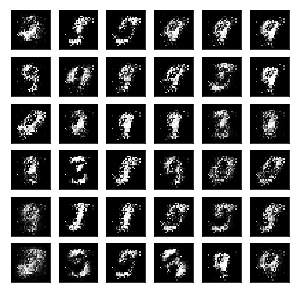

 32%|███▏      | 8/25 [03:09<06:43, 23.73s/it]

Epoch[9/25], G Loss: -0.0811, D Loss: 0.2213


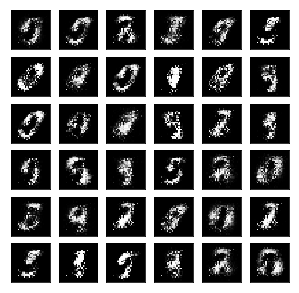

 36%|███▌      | 9/25 [03:44<06:39, 25.00s/it]

Epoch[10/25], G Loss: -0.0939, D Loss: 0.2324
Epoch[12/25], G Loss: -0.0925, D Loss: 0.2376


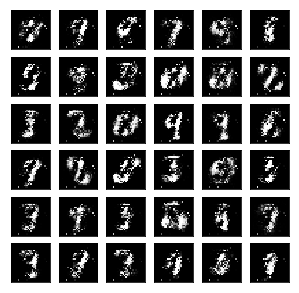

 48%|████▊     | 12/25 [05:11<05:37, 25.96s/it]

Epoch[13/25], G Loss: -0.1137, D Loss: 0.3007


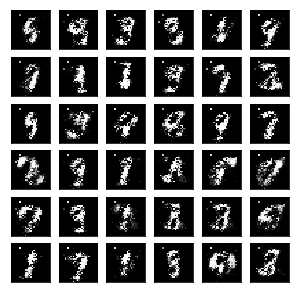

 52%|█████▏    | 13/25 [05:38<05:12, 26.07s/it]

Epoch[14/25], G Loss: -0.0876, D Loss: 0.2235


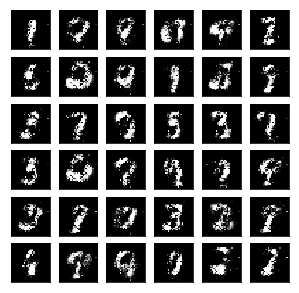

 56%|█████▌    | 14/25 [06:07<04:49, 26.28s/it]

Epoch[15/25], G Loss: -0.0958, D Loss: 0.2362


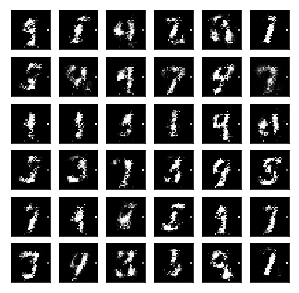

 60%|██████    | 15/25 [06:34<04:23, 26.33s/it]

Epoch[16/25], G Loss: -0.0996, D Loss: 0.2492


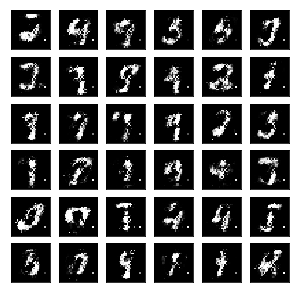

 64%|██████▍   | 16/25 [07:01<03:57, 26.34s/it]

Epoch[17/25], G Loss: -0.0930, D Loss: 0.2419


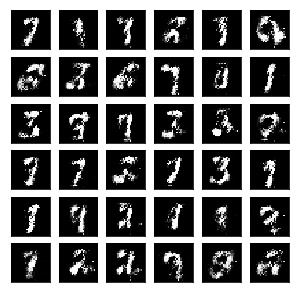

 68%|██████▊   | 17/25 [07:27<03:30, 26.35s/it]

Epoch[18/25], G Loss: -0.1101, D Loss: 0.2755


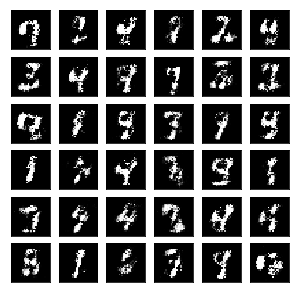

 72%|███████▏  | 18/25 [07:55<03:04, 26.42s/it]

Epoch[19/25], G Loss: -0.1222, D Loss: 0.2978


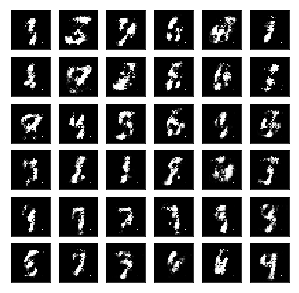

 76%|███████▌  | 19/25 [08:25<02:39, 26.61s/it]

Epoch[20/25], G Loss: -0.0865, D Loss: 0.2090


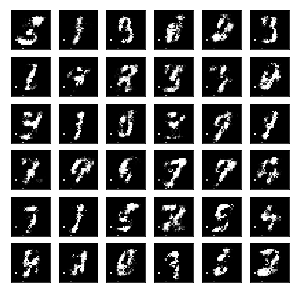

 80%|████████  | 20/25 [08:55<02:13, 26.76s/it]

Epoch[21/25], G Loss: -0.0668, D Loss: 0.1670


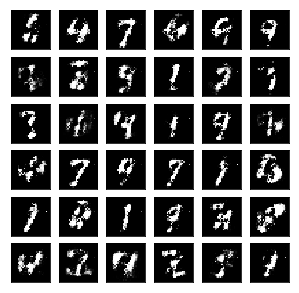

 84%|████████▍ | 21/25 [09:24<01:47, 26.89s/it]

Epoch[22/25], G Loss: -0.1112, D Loss: 0.2612


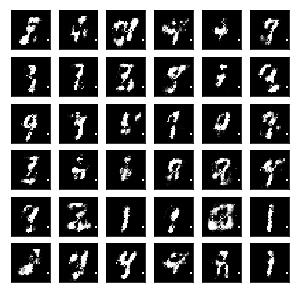

 88%|████████▊ | 22/25 [09:55<01:21, 27.07s/it]

Epoch[23/25], G Loss: -0.0799, D Loss: 0.1948


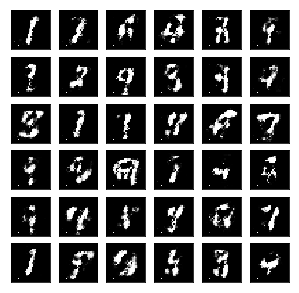

 92%|█████████▏| 23/25 [10:23<00:54, 27.09s/it]

Epoch[24/25], G Loss: -0.1016, D Loss: 0.2394


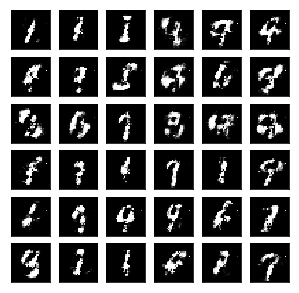

 96%|█████████▌| 24/25 [10:52<00:27, 27.20s/it]

Epoch[25/25], G Loss: -0.1162, D Loss: 0.2708


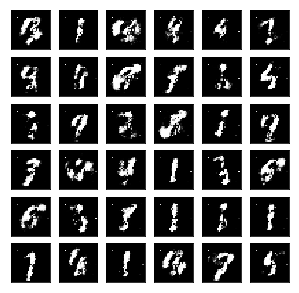

100%|██████████| 25/25 [11:24<00:00, 27.36s/it]


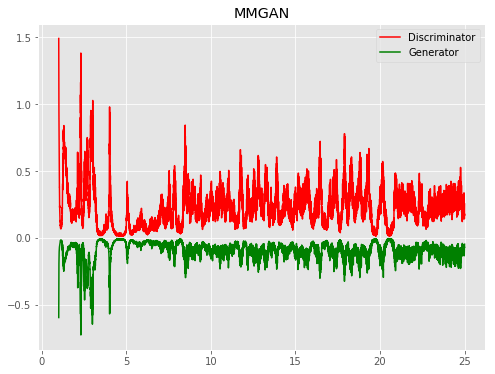

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../src/')))
from mm_gan import *

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binzarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

# Init model
model = MMGAN(image_size=784,
              hidden_dim=400,
              z_dim=20)

# Init trainer
trainer = MMGANTrainer(model=model,
                       train_iter=train_iter,
                       val_iter=val_iter,
                       test_iter=test_iter,
                       viz=True)

# Train
trainer.train(num_epochs=25,
              G_lr=2e-4,
              D_lr=2e-4,
              D_steps=1,
              G_init=5)

# Show loss
trainer.viz_loss()